## Install package

Puedes instalar las dependencias listadas en el archivo `requirements.txt` utilizando el siguiente comando:

```bash
pip install -r requirements.txt

In [7]:
# pip install -r requirements.txt

## Data

In [8]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

import pyproj
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.pipeline import FeatureUnion

# import shapely.geometry
# from sklearn.model_selection import train_test_split


def clean_conducta(conducta):
    conducta = conducta.upper()
    conducta = conducta.replace(" ", "_")
    conducta = re.sub(
        r"[ÁÉÍÓÚ]",
        lambda m: m.group(0)
        .replace("Á", "A")
        .replace("É", "E")
        .replace("Í", "I")
        .replace("Ó", "O")
        .replace("Ú", "U"),
        conducta,
    )
    conducta = conducta.replace("Ñ", "N")
    return conducta

crimes_df = pd.read_csv("./base_crim16_08.csv")

# Select relevant features
features = [
    "fecha_hecho",
    "fecha",
    "codigo_barrio",
    "year",
    "mes",
    "dia",
    "latitud",
    "longitud",
    "conducta",
]
crimes_df = crimes_df[features]
# "hora",
# "minuto",


crimes_df["fecha_hecho"] = pd.to_datetime(
    crimes_df["fecha_hecho"], format="%d/%m/%Y %H:%M"
)
crimes_df = crimes_df[
    (crimes_df["year"] >= 2008) & (crimes_df["year"] <= 2009)
]  # ? Select year 2008 and 2009

print("crimes_df data shape ", crimes_df.shape)
print(crimes_df.isnull().sum())  # check for missing values
crimes_df = crimes_df.dropna()  # drop missing values
crimes_df = crimes_df.drop_duplicates()  # elimianr los datos repetidos
# print("\ncrimes dtypes: ", crimes_df.dtypes)


# ? DATE TIME STAMP FUNCTION
column_1 = crimes_df.iloc[:, 0]

db = pd.DataFrame(
    {
        "dayofyear": column_1.dt.dayofyear,
        "weekofyear": column_1.dt.isocalendar().week,
        "quarter": column_1.dt.quarter,
        "weekday": column_1.dt.weekday,
        "weekend": np.where(column_1.dt.weekday >= 4, 1, 0),
        # "Season": (
        #     column_1 - pd.DateOffset(months=1)
        # ).dt.quarter,
    }
)


crimes_df = crimes_df.drop("fecha_hecho", axis=1)  #! drop fecha_hecho
crimes_df = pd.concat([db, crimes_df], axis=1)
crimes_df["conducta"] = crimes_df["conducta"].apply(clean_conducta)
# data = pd.get_dummies(crimes_df.conducta)
# crimes_df = pd.concat([data, crimes_df], axis=1)


crimes_df["codigo_barrio"] = crimes_df["codigo_barrio"].astype(str).str.replace("#", "")
crimes_df["codigo_barrio"] = pd.to_numeric(crimes_df["codigo_barrio"], errors="coerce")
crimes_df.head(10)

crimes_df data shape  (17707, 9)
fecha_hecho         0
fecha               0
codigo_barrio       0
year                0
mes                 0
dia                 0
latitud          4143
longitud         4143
conducta            0
dtype: int64


,dayofyear,weekofyear,quarter,weekday,weekend,fecha,codigo_barrio,year,mes,dia,latitud,longitud,conducta
18880,1,1,1,1,0,1/01/2008,405,2008,1,1,6.274160,-75.566394,HURTO_DE_CARRO
18886,3,1,1,3,0,3/01/2008,1109,2008,1,3,6.240525,-75.601892,HURTO_DE_CARRO
18891,4,1,1,4,1,4/01/2008,912,2008,1,4,6.237972,-75.561801,HURTO_DE_CARRO
18892,4,1,1,4,1,4/01/2008,1606,2008,1,4,6.218799,-75.598960,HURTO_DE_CARRO
18896,5,1,1,5,1,5/01/2008,1105,2008,1,5,6.239474,-75.582965,HURTO_DE_CARRO
18898,6,1,1,6,1,6/01/2008,1109,2008,1,6,6.242487,-75.601913,HURTO_DE_CARRO
18901,7,2,1,0,0,7/01/2008,905,2008,1,7,6.234173,-75.542728,HURTO_DE_CARRO
18905,9,2,1,2,0,9/01/2008,1015,2008,1,9,6.242116,-75.560736,HURTO_DE_CARRO
18906,9,2,1,2,0,9/01/2008,1309,2008,1,9,6.256918,-75.617078,HURTO_DE_CARRO
18913,10,2,1,3,0,10/01/2008,607,2008,1,10,6.290093,-75.584201,HURTO_DE_CARRO


### SHP and intersections

#### Grids

In [9]:
# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
# to_proxy_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")
# to_original_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")


# # Definir la función de conversión de grados a metros
# def convertir_lat_long_a_metros(lat, long):
#     transformed = to_proxy_transformer.transform(lat, long)
#     return transformed[0], transformed[1]


# # Perform spatial join by rounding coordinates for more accurate intersection
# # def round_coords(geom):
# #     if geom.type == "Polygon":
# #         return shapely.geometry.Polygon(
# #             [(round(x, 4), round(y, 4)) for x, y in geom.exterior.coords]
# #         )
# #     elif geom.type == "Point":
# #         return Point(round(geom.x, 4), round(geom.y, 4))
# #     else:
# #         return geom


# def create_gdf(df):
#     gdf = df.copy()
#     gdf["Coordinates"] = list(zip(gdf.longitud, gdf.latitud))
#     gdf.Coordinates = gdf.Coordinates.apply(Point)
#     gdf = gpd.GeoDataFrame(gdf, geometry="Coordinates", crs="epsg:32618")
#     return gdf


# # Leer el archivo SHP y crear un objeto GeoDataFrame
# ruta_archivo_shp = "shp/BarrioVereda_2014.shp"
# #ruta_archivo_shp = "shp/map.shp"
# gdf = gpd.read_file(ruta_archivo_shp)

# # Filtrar por el código de comunas de Medellín (son 16 comunas en total)
# gdf = gdf[gdf["LIMITECOMU"] < "17"]

# # Reproyectar a coordenadas planas
# gdf = gdf.to_crs(epsg=32618)

# print(gdf.columns.tolist()) #mostar los nombres de las columnas de la base

# # Crear el polígono único que representa el límite exterior de todos los polígonos
# outter_map = gdf.unary_union

# # Crear un nuevo GeoDataFrame con el polígono del límite exterior
# gdf_outter = gpd.GeoDataFrame(geometry=[outter_map], crs=gdf.crs)

# xmin, ymin, xmax, ymax = gdf_outter.total_bounds
# print("xmin:", xmin, "ymin:", ymin, "xmax:", xmax, "ymax:", ymax)

# stepsize = 200  # 200 meters grid step size

# # Iterate over 2D area and create grid squares (boxes) with consecutive grid_id
# gridboxes = []
# grid_id = 1  # Initialize grid_id to start from 1
# x = xmin
# while x < xmax:
#     y = ymin
#     while y < ymax:
#         box = shapely.geometry.box(x, y, x + stepsize, y + stepsize)
#         box_properties = {"geometry": box, "grid_id": grid_id}
#         gridboxes.append(box_properties)
#         grid_id += 1  # Increment grid_id for the next box
#         y += stepsize
#     x += stepsize

# # Create a GeoDataFrame from gridboxes
# grid_gdf = gpd.GeoDataFrame(gridboxes, crs=gdf.crs)
# # grid_gdf["geometry"] = grid_gdf["geometry"].apply(round_coords)

# print(grid_gdf.columns.tolist()) #mostar los nombres de las columnas de la base AQUI SE MUESTRA AREA

# # Perform spatial join
# grid_outter_gdf = gpd.sjoin(grid_gdf, gdf_outter, how="inner", op="within")
# # grid_outter_gdf["geometry"] = grid_outter_gdf["geometry"].apply(round_coords)

# print(grid_outter_gdf.columns.tolist()) #mostar los nombres de las columnas de la base AQUI SE MUESTRA AREA

# # **** 2. Cargar los datos de los delitos ****
# crimes_gdf = create_gdf(crimes_df)
# print(len(crimes_gdf))
# # crimes_gdf["Coordinates"] = crimes_gdf["Coordinates"].apply(round_coords)

# # Convertir las coordenadas de latitud y longitud a metros y crear una nueva columna
# crimes_gdf["Coordinates"] = crimes_gdf.apply(
#     lambda row: Point(*convertir_lat_long_a_metros(row["latitud"], row["longitud"])),
#     axis=1,
# )


# # eliminar todos los coordinates que tengan infinity
# crimes_gdf = crimes_gdf[
#     crimes_gdf["Coordinates"].apply(lambda x: not np.isinf(x.coords[0][0]))
# ]

# # eliminar todos los registros que tengan latitud y longitud 0
# crimes_gdf = crimes_gdf[
#     crimes_gdf["Coordinates"].apply(
#         lambda x: x.coords[0][0] != 0 and x.coords[0][1] != 0
#     )
# ]

# # Realizar la intersección usando gpd.sjoin()
# crimes_gdf = gpd.sjoin(
#     crimes_gdf, grid_outter_gdf[["grid_id", "geometry"]], how="inner", op="within"
# )
# print(len(crimes_gdf))

# # eliminar columna de index_right
# crimes_gdf = crimes_gdf.drop(columns=["index_right"])

# print(crimes_gdf.head())

# print("\n --------------------")

# print(grid_outter_gdf.head())

# # Plot the map and grid squares
# fig, ax = plt.subplots(figsize=(10, 8))
# grid_outter_gdf.plot(ax=ax, color="white", edgecolor="black")
# crimes_gdf.plot(ax=ax, color="red", markersize=1)
# # gdf_outter.plot(ax=ax, color='lightgray', edgecolor='black')


# plt.title("Mapa con cuadrícula de cuadrados de 200 metros")
# plt.xlabel("Longitud (EPSG:32618)")
# plt.ylabel("Latitud (EPSG:32618)")
# plt.show()
#print(gdf.columns.tolist()) #para ver el nombre de las columnas de una base de datos

### Barrios

In [10]:
# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")
to_original_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")

# Definir la función de conversión de grados a metros
def convertir_lat_long_a_metros(lat, long):
    transformed = to_proxy_transformer.transform(lat, long)
    return transformed[0], transformed[1]

def create_gdf(df):
    gdf = df.copy()
    gdf["Coordinates"] = list(zip(gdf.longitud, gdf.latitud))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(gdf, geometry="Coordinates", crs="epsg:32618")
    return gdf

crimes_gdf = create_gdf(crimes_df)
# print("len crimes_gdf ->",len(crimes_gdf))

# Convertir las coordenadas de latitud y longitud a metros y crear una nueva columna
crimes_gdf["Coordinates"] = crimes_gdf.apply(
    lambda row: Point(*convertir_lat_long_a_metros(row["latitud"], row["longitud"])),
    axis=1,
)

# eliminar todos los coordinates que tengan infinity
crimes_gdf = crimes_gdf[
    crimes_gdf["Coordinates"].apply(lambda x: not np.isinf(x.coords[0][0]))
]

# eliminar todos los registros que tengan latitud y longitud 0
crimes_gdf = crimes_gdf[
    crimes_gdf["Coordinates"].apply(
        lambda x: x.coords[0][0] != 0 and x.coords[0][1] != 0
    )
]

# ***************** Leer el archivo SHP y crear un objeto GeoDataFrame ***************
ruta_shp = "shp/map.shp"
gdf = gpd.read_file(ruta_shp)

# Filtrar por el código de comunas de Medellín (son 16 comunas en total)
gdf = gdf[gdf["LIMITECOMU"] < "17"]

# Reproyectar a coordenadas planas
gdf = gdf.to_crs(epsg=32618)

# imprimir algunas filas del archivo shp
print(gdf.head(5))

# Realizar la intersección usando gpd.sjoin()
crimes_gdf = gpd.sjoin(
    crimes_gdf, gdf[["area","geometry"]], how="inner", op="within"
)

# eliminar columna de index_right
crimes_gdf = crimes_gdf.drop(columns=["index_right"])

print("\n ---------------------------------------------------------- \n")
print(crimes_gdf.sample(5))

    CODIGO                  NOMBRE  ABREVIATUR IDENTIFICA LIMITECOMU  \
0  Inst_15                   U.P.B         NaN    Inst_15         11   
1  Inst_18          Cerro Nutibara         NaN    Inst_18         16   
2     0610        Mirador del Doce         NaN       0610         06   
3     1620  El Nogal-Los Almendros         NaN       1620         16   
4     0612              El Triunfo         NaN       0612         06   

   ZHFISICAGE LIMITEMUNI  VIGENCIA_F  SUBTIPO_BA  LINK_DOCUM           area  \
0         NaN        001         NaN         1.0         NaN  216275.239275   
1         NaN        001         NaN         1.0         NaN  398713.874885   
2         NaN        001         NaN         1.0         NaN   64749.995150   
3         NaN        001         NaN         1.0         NaN  248088.656801   
4         NaN        001         NaN         1.0         NaN  116938.310530   

                                            geometry  
0  POLYGON ((434831.540 690264.857, 4

c:\Users\Nicolas\Documents\TRABAJOS\TESIS_CAMILA\workspace_python\myvenv39\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [11]:
# Eliminar espacios al principio y al final de los valores
crimes_gdf["fecha"] = crimes_gdf["fecha"].str.strip()

# Convertir a datetime
crimes_gdf["fecha"] = pd.to_datetime(crimes_gdf["fecha"], format="%d/%m/%Y")

# Agrupar los datos por 'codigo_barrio', 'fecha' y 'conducta' y contar las ocurrencias
crime_count_per_day = crimes_gdf.groupby(
    ["codigo_barrio", "fecha", "conducta"]
).size()  # ,'year'

# Desapilar y rellenar los datos faltantes con 0
crime_count_per_day = (
    crime_count_per_day.unstack(["codigo_barrio", "conducta"])
    .asfreq("D")
    .fillna(0)
    .stack(["codigo_barrio", "conducta"])
    .reset_index(name="crime_count")
)

crime_count_per_day = pd.DataFrame(crime_count_per_day)

crime_count_per_day = crime_count_per_day.merge(
    crimes_gdf[
        [
            "codigo_barrio",
            "area",
        ]
    ],
    on="codigo_barrio",
    how="inner",
)
crime_count_per_day.sample(5)
# crime_count_per_day.to_csv('crimecount.csv')

,fecha,codigo_barrio,conducta,crime_count,area
1802295,2009-05-10,308,HURTO_A_PERSONA,0.0,372850.430879
8664702,2008-04-06,1006,HOMICIDIO,0.0,492771.466673
1741865,2008-08-18,308,HURTO_A_PERSONA,0.0,372850.430879
7626082,2009-08-19,909,HOMICIDIO,0.0,471721.652052
11745427,2009-07-31,1019,HURTO_A_RESIDENCIA,0.0,648464.856499


### Alpha

In [12]:
alpha = 7
aslice = pd.DataFrame()
for cond in crime_count_per_day["conducta"].unique():
    for cod in crime_count_per_day["codigo_barrio"].unique():
        # Slice data per cod-conducta
        dslice = crime_count_per_day.query(
            "conducta == @cond and codigo_barrio == @cod"
        )[["codigo_barrio", "conducta", "fecha", "crime_count"]]
        # Rolling sum, don't allow starting nan:s
        rollslice = (
            dslice[["fecha", "crime_count"]]
            .rolling(alpha, center=False, on="fecha")
            .sum()
            .fillna(method="bfill")
        )
        rollslice = rollslice.rename(columns={"crime_count": "Rolling_sum"})
        # merge
        dslice = dslice.merge(rollslice, on="fecha", how="left").drop(
            "crime_count", axis=1
        )
        aslice = pd.concat([aslice, dslice], ignore_index=True)
# merge with main table
crime_count_per_day = crime_count_per_day.merge(
    aslice, on=["fecha", "codigo_barrio", "conducta"], how="left"
)
colnames = ["alpha_crime_dens_area_" + str(alpha)]
# normalize
crime_count_per_day[colnames[0]] = (
    crime_count_per_day["Rolling_sum"] / crime_count_per_day["area"]
)
crime_count_per_day = crime_count_per_day.drop("Rolling_sum", axis=1)

MemoryError: Unable to allocate 4.58 GiB for an array with shape (1, 614954481) and data type float64

In [ ]:
alpha = 30
aslice = pd.DataFrame()

for cond in crime_count_per_day["conducta"].unique():
    for cod in crime_count_per_day["codigo_barrio"].unique():
        dslice = crime_count_per_day.query(
            "conducta == @cond and codigo_barrio == @cod"
        )[["codigo_barrio", "conducta", "fecha", "crime_count"]]
        rollslice = (
            dslice[["fecha", "crime_count"]]
            .rolling(alpha, center=False, on="fecha")
            .sum()
            .fillna(method="bfill")
        )
        rollslice = rollslice.rename(columns={"crime_count": "Rolling_sum"})
        dslice = dslice.merge(rollslice, on="fecha", how="left").drop(
            "crime_count", axis=1
        )
        aslice = pd.concat([aslice, dslice], ignore_index=True)

crime_count_per_day = crime_count_per_day.merge(
    aslice, on=["fecha", "codigo_barrio", "conducta"], how="left"
)

colnames = ["alpha_crime_dens_area_" + str(alpha)]
crime_count_per_day[colnames[0]] = (
    crime_count_per_day["Rolling_sum"] / crime_count_per_day["area"]
)
crime_count_per_day = crime_count_per_day.drop("Rolling_sum", axis=1)

### Load and Merge characteristics

In [ ]:


crime_count_per_day = crime_count_per_day.merge(
    crimes_gdf[
        [
            "codigo_barrio",
            "weekday",
            "weekend",
            "dayofyear",
            "weekofyear",
            "quarter",
        ]
    ],
    on="codigo_barrio",
    how="inner",
)
crime_count_per_day.sample(5)
# crime_count_per_day.to_csv('crimecount.csv')

In [ ]:
characteristics = pd.read_excel("./characteristics.xlsx")
#characteristics=characteristics[['CODIGO','year','edad','inseg','gender','atraco','seg', 'casado','pensionado', 'estra_12', 'ofi_hogar', 'acu_si','ipm','childhood','youth','adult','def_cuantitativo','def_cualitativo']]
characteristics=characteristics[['CODIGO','year','edad','inseg','atraco','seg','ipm','youth','adult','def_cuantitativo','def_cualitativo']]

# eliminaar registros que tengan CODIGO null nan o con un caracter '.'
characteristics = characteristics[characteristics["CODIGO"].notna()]
characteristics = characteristics[characteristics["CODIGO"] != "."]

# convertir a entero el codigo
characteristics["CODIGO"] = characteristics["CODIGO"].astype(int)

# renombrar columna de characteristics "CODIGO" a "codigo_barrio"
characteristics = characteristics.rename(columns={"CODIGO": "codigo_barrio"})

# Se realiza el merge de crime_count_per_day characteristics left de crime_count_per_day
crime_count_per_day['year'] = pd.to_datetime(crime_count_per_day['fecha']).dt.year
crime_count_per_day = crime_count_per_day.merge(characteristics, how='left', on=['codigo_barrio', 'year'])

print("-> Missing values: \n")
print(crime_count_per_day.isnull().sum())
# drop missing values
print("-> Dropping missing values: \n")
crime_count_per_day = crime_count_per_day.dropna()
# elimianr los datos repetidos
print("-> Eliminar los datos repetidos \n")
crime_count_per_day = crime_count_per_day.drop_duplicates()

crime_count_per_day.sample(10)

In [ ]:
# Description of our new dataset 
crime_count_per_day.describe()

In [ ]:
crime_count_per_day.dtypes

In [ ]:
#Instances of crime_count per date, neighborhood, and crime category
cc = crime_count_per_day.groupby('crime_count').size()
fig, axes = plt.subplots(1, 2, figsize=(14, 4));
cc.plot.bar(logy=False, ax=axes[0], title='Instances of crime_count, lin axes');
cc.plot.bar(logy=True, ax=axes[1], title='Instances of crime_count, log-lin axes');

In [ ]:
# save crime count per day into csv file
# crime_count_per_day.to_csv("crime_count_per_day.csv", index=False)

### Correlation features

In [ ]:
# import seaborn as sns
# sns.set()
# crime_count_per_day_cd = crime_count_per_day.drop(['conducta','crime_count'], axis=1)

# #Adding dummy feature to get full cmap scale (really complicated to solve in sns/matplotlib)
# crime_count_per_day_cd['dummy_feature'] = -crime_count_per_day_cd['pensionado']
# corr = crime_count_per_day_cd.corr()

# # Create a heatmap
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(corr,
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values,
#             cmap='RdBu_r',
#             ax=ax)

# # Remove the dummy feature
# crime_count_per_day_cd = crime_count_per_day_cd.drop('dummy_feature', axis=1)

# plt.show()

### Train-dev-test split

In [2]:
# Sort columns on name for easier handling of predictions downstream
crime_data_grd = crime_count_per_day.reindex(
    sorted(crime_count_per_day.columns), axis=1
)


X_train = crime_data_grd[crime_data_grd['year'] <= 2008] 
#crime_data_grd.query('fecha < "2018-01-01"')
X_test = crime_data_grd[crime_data_grd['year'] == 2009]  
#crime_data_grd.query('fecha >= "2018-01-01"')

#labels for classifier
y_train_clf = X_train['crime_count'].clip(upper=1).astype(int)
y_test_clf = X_test['crime_count'].clip(upper=1).astype(int)

#labels for regression
y_train_reg = X_train['crime_count']
y_test_reg = X_test['crime_count']

#Clean
X_train = X_train.drop(['crime_count','fecha','year','codigo_barrio'],axis=1)
X_test = X_test.drop(['crime_count','fecha','year','codigo_barrio'],axis=1)

#Check split ratios
time_split = int(len(X_train)/(len(crime_data_grd))*100)
event_split = int(y_train_clf.sum()/(y_train_clf.sum()+y_test_clf.sum())*100)
print("Train/test split in time: {}/{}".format(time_split, 100-time_split))
print("Train/test split in events: {}/{}".format(event_split, 100-event_split))

Train/test split in time: 49/51
Train/test split in events: 42/58


In [4]:
X_train.sample(10)

,adult,alpha_crime_dens_area_30,alpha_crime_dens_area_7,area,atraco,conducta,def_cualitativo,def_cuantitativo,edad,inseg,ipm,seg,weekday,weekend,youth
60232,0.628742,0.000000,0.0,328010.204911,0.047904,HURTO_DE_CARRO,1.000000,0.131737,40.961079,0.266467,0.787425,0.640719,4,1,0.233533
70131,0.560440,0.000000,0.0,304828.725149,0.043956,EXTORSION,1.000000,0.065934,38.197803,0.197802,0.725275,0.505494,4,1,0.318681
1635729,0.555882,0.000003,0.0,355161.077695,0.091176,HOMICIDIO,1.000000,0.017647,37.347057,0.232353,0.732353,0.767647,0,0,0.294118
1847472,0.640000,0.000000,0.0,291109.482445,0.035000,HURTO_A_PERSONA,0.900000,0.000000,41.654999,0.315000,0.790000,0.665000,4,1,0.260000
1479967,0.418182,0.000000,0.0,646912.154798,0.019481,HURTO_A_RESIDENCIA,0.825974,0.157143,29.396105,0.092208,0.679221,0.876623,3,0,0.302597
466696,0.568365,0.000000,0.0,554020.561780,0.018767,EXTORSION,0.970509,0.000000,38.356567,0.152815,0.777480,0.697051,6,1,0.297587
1050872,0.610561,0.000000,0.0,605458.576300,0.026403,HURTO_DE_CARRO,0.825083,0.000000,38.712872,0.115512,0.729373,0.534654,4,1,0.240924
65666,0.668224,0.000000,0.0,363497.064123,0.056075,HURTO_DE_CARRO,1.000000,0.046729,44.448597,0.126168,0.808411,0.845794,0,0,0.252336
1247475,0.585443,0.000000,0.0,695853.232847,0.126582,HURTO_A_PERSONA,0.933544,0.000000,37.781647,0.174051,0.693038,0.658228,3,0,0.275316
1620448,0.461078,0.000006,0.0,166325.961979,0.011976,HOMICIDIO,0.922156,0.131737,31.514971,0.041916,0.736527,0.724551,6,1,0.299401


### Model preprocessing pipeline

In [5]:
#source: https://github.com/ageron/handson-ml
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    """Binarize Label in a One vs all fashion. This utility class would
    enable people to use this with categorical variables in pipelines.
    Refer to LabelBinarizer for detailed info.
    """

    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)

    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)


In [6]:
#Numerical features. Using a StandardScaler to be insensitive to any outliers.
num_attributes = X_train.select_dtypes(exclude=[object]).columns
num_mapper = DataFrameMapper(gen_features(
    columns=[[f] for f in num_attributes],
    classes=[
            StandardScaler
            ]
))

#Categorical features. One-hot encode (binarize) the features.
cat_attributes = X_train.select_dtypes(include=[object]).columns
cat_mapper = DataFrameMapper(gen_features(
    columns=[[f] for f in cat_attributes],
    classes=[LabelBinarizerPipelineFriendly]
))

#Union
full_pipeline = FeatureUnion(transformer_list=[
    ('num_mapper', num_mapper),
    ('cat_mapper', cat_mapper),
])

X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.transform(X_test)
print(num_attributes)
print(cat_attributes)
print(np.shape(X_train_prep))
print(X_train_prep[1])


Index(['adult', 'alpha_crime_dens_area_30', 'alpha_crime_dens_area_7', 'area',
       'atraco', 'def_cualitativo', 'def_cuantitativo', 'edad', 'inseg', 'ipm',
       'seg', 'weekday', 'weekend', 'youth'],
      dtype='object')
Index(['conducta'], dtype='object')
(1906264, 19)
[-1.21207221 -0.38900626 -0.23192062  0.78086656 -0.33657963 -1.30359215
  1.26110174 -1.3730267   0.98474773  0.59322747 -0.08705057  1.50002932
  1.14845003 -0.1145486   0.          1.          0.          0.
  0.        ]


### Hyperparameter grid search

In [7]:
# from scipy.stats import randint as sp_randint
# from sklearn.metrics import precision_recall_curve, confusion_matrix, make_scorer, classification_report
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
# def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
# def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
# def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
# def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
# def get_standard_scores():
#     scores = {'recall' : 'recall', 'precision' : 'precision',
#     'roc_auc' : 'roc_auc', 'avg_precision' : 'average_precision',
#     'f1' : 'f1', 
#     'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
#     'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}
#     return scores
# #Uncomment the three bottom lines in the cell and it'll search and print the results.
# param_grid = {
#     'max_depth': sp_randint(5, 80),
#     'n_estimators' : sp_randint(1, 200),
#     'min_samples_leaf' : sp_randint(1, 400),
#     'random_state' : [42],
#     'max_features' : ['auto'],
#     'class_weight' : ['balanced', None]
#     }
# def generate_results_df(grid_searcher, scores, generate_files=False):
#     #keep all columns for future analyses
#     result_df_full = pd.DataFrame(grid_searcher.cv_results_)
#     #create a nimbler df
#     result_df_compact = pd.DataFrame(index=result_df_full.index)
#     for col in [col for col in result_df_full.columns if 'mean_test' in col]:
#         #First, check to see if we have a mean_test_score column, whcih indicates only one unnamed metric (from BayesSearchCV)
#         #If so, fill in name; else, handle multiple metrics. We don't have to break the loop, since mean_test_score implies only one 'mean_test'-column.
#         if 'mean_test_score' in col and type(scores) is str:
#             result_df_compact[scores] = result_df_full[[col, col.replace('mean_', 'std_')]].round(3).astype(str).apply(lambda x: ' +/- '.join(x), axis=1)
#         else:
#             #Confusion matrix must be handled separately
#             if '_tp' not in col and '_tn' not in col and '_fn' not in col and '_fp' not in col:
#                 result_df_compact[col.replace('mean_test_','')] = result_df_full[[col, col.replace('mean_', 'std_')]].round(3).astype(str).apply(lambda x: ' +/- '.join(x), axis=1)
#             else:
#                 #only do the confusion once
#                 if 'tp_fp_fn_tn' not in result_df_compact.columns:
#                     for metric in ['tp','fp','fn','tn']:
#                         #sum confusion matrix elements to match total number of samples
#                         result_df_full[metric+'_sum'] = result_df_full[[column for column in result_df_full.columns if metric in column and 'split' in column]].sum(axis=1)
#                     result_df_compact['tp_fp_fn_tn'] = result_df_full[['tp_sum', 'fp_sum', 'fn_sum', 'tn_sum']].astype(int).astype(str).apply(lambda x: '/'.join(x), axis=1)
#     result_df_compact['time_fit_score'] = result_df_full[['mean_fit_time', 'mean_score_time']].round(3).astype(str).apply(lambda x: ' + '.join(x), axis=1)
#     #add all parameters individually to the compact df
#     param_cols=[col for col in result_df_full.columns if 'param_' in col]
#     #transfer all parameter columns to compact df
#     for col in param_cols:
#         result_df_compact[col] = result_df_full[col].copy()
#     #we usually want to save the results in a file
#     if generate_files:
#         estimator=str(grid_searcher.estimator).split('(')[0]+'_'
#         #If we use a pipeline, list all estimators/samplers/tranformers in the file name
#         if estimator=='Pipeline_':
#             estimator=""
#             for key, value in grid_searcher.estimator.named_steps.items():
#                 estimator+=str(value).split('(')[0]+'_'
#         #TODO: set output dir of file
#         opwd = './'
#         ofile = 'Results_df_'+estimator+time.strftime("%Y%m%d_%H%M%S")+'.csv'
#         result_df_compact.to_csv(opwd+ofile, sep=',')
#         ofile = 'Full_results_df_'+estimator+'_'+time.strftime("%Y%m%d_%H%M%S")+'.csv'
#         result_df_full.to_csv(opwd+ofile, sep=',')
#     return result_df_full, result_df_compact

# scores = get_standard_scores()

# n_iter = 10; cv=3
# rfc = RandomForestClassifier()
# rnd_search = RandomizedSearchCV(rfc, param_grid, n_iter=n_iter, cv=cv, scoring=scores, n_jobs=-1, refit=False, return_train_score=False, verbose=2)
# rnd_search.fit(X_train_prep, y_train_clf)

# _, gs_df = generate_results_df(rnd_search, scores)
# gs_df.sort_values(by='avg_precision', ascending=False)

In [8]:
from scipy.stats import randint as sp_randint
from sklearn.metrics import precision_recall_curve, confusion_matrix, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV

#Select best models: best balanced classes and unbalanced classes. 
#Could use refit=True in search above if you want to include search and run code top-to-bottom.
rfc1 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=None, max_depth=77, n_estimators=81, min_samples_leaf=152)
rfc1.fit(X_train_prep, y_train_clf)
#rfc2 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced', max_depth=69, n_estimators=64, min_samples_leaf=132)
#rfc2.fit(X_train_prep, y_train_clf)

RandomForestClassifier(max_depth=77, min_samples_leaf=152, n_estimators=81,
                       n_jobs=-1, random_state=42)

### Model evaluation

In [9]:
def obtain_and_plot_evaluation_figures(model, X, y, method, datatype, cv=3, verbose=100, title_prefix=None):
    if datatype == 'train':
        y_pred = cross_val_predict(model, X, y, cv=cv, method=method, verbose=verbose)
    elif datatype == 'test':
        y_pred = model.predict_proba(X)
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred[:,1])
        #y_pred = model.predict_proba(X)
        
    # if datatype == 'train':
    #     precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
    # else:
    #     precisions, recalls, thresholds = precision_recall_curve(y, y_pred)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5));
    ax1.plot(thresholds, precisions[:-1], "b--", label="Precision");
    ax1.plot(thresholds, recalls[:-1], "g-", label="Recall");
    ax1.set(xlabel="Thresholds");
    ax1.set_ylim([0,1]);
    ax1.legend();
    ax1.set_title(title_prefix + 'Precision & recall at thresholds');

    ax2.plot(precisions, recalls, label=None);
    ax2.set_ylim([0,1]);
    ax2.set_xlim([0,1]);
    ax2.set(xlabel="Precision", ylabel="Recall");
    ax2.set_title(title_prefix + 'Precision-recall curve');
    print(np.shape(y_pred))

In [ ]:
# pip install joblib


In [10]:
import joblib
# Guardar el modelo en un archivo con compresión
model_filename = 'random_forest_model_compre_27_08.joblib'
joblib.dump(rfc1, model_filename, compress=5)  # El valor 3 controla el nivel de compresión
# Cargar el modelo desde el archivo
loaded_model = joblib.load(model_filename)

In [11]:
print(y_train_clf.head())

print(y_train_clf.shape)

0    0
1    0
2    0
3    0
4    0
Name: crime_count, dtype: int32
(1906264,)


(1906264, 2)


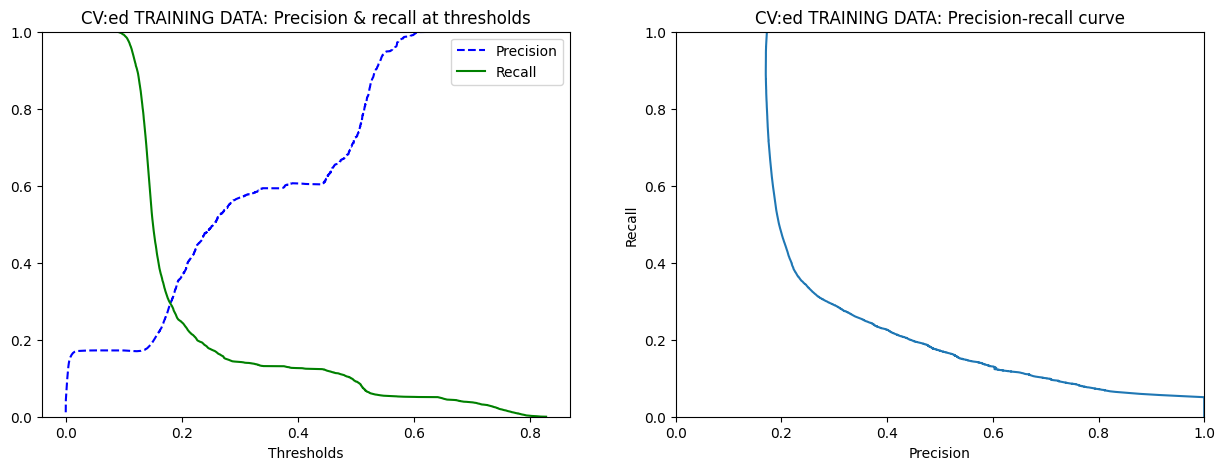

In [12]:
obtain_and_plot_evaluation_figures(model=rfc1, X=X_train_prep, y=y_train_clf, datatype='train', method='predict_proba', cv=3, verbose=0, title_prefix='CV:ed TRAINING DATA: ')

(1907540, 2)


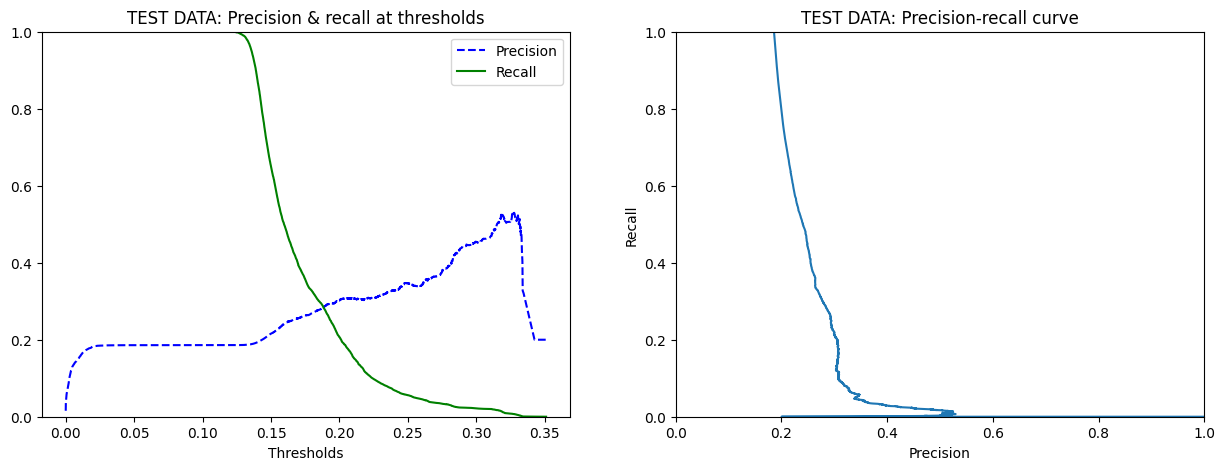

In [13]:
obtain_and_plot_evaluation_figures(model=rfc1, X=X_test_prep, y=y_test_clf, datatype='test', method='predict_proba', verbose=0, title_prefix='TEST DATA: ')

In [15]:
print('CV:ed TRAINING DATA: \n' + classification_report(y_train_clf, cross_val_predict(rfc1, X_train_prep, y_train_clf, cv=3)))
print('TEST DATA: \n' + classification_report(y_test_clf, rfc1.predict(X_test_prep)))

CV:ed TRAINING DATA: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1884375
           1       0.73      0.09      0.16     21889

    accuracy                           0.99   1906264
   macro avg       0.86      0.55      0.58   1906264
weighted avg       0.99      0.99      0.98   1906264



c:\Users\Nicolas\Documents\TRABAJOS\TESIS_CAMILA\workspace_python\myvenv39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nicolas\Documents\TRABAJOS\TESIS_CAMILA\workspace_python\myvenv39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TEST DATA: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1878014
           1       0.00      0.00      0.00     29526

    accuracy                           0.98   1907540
   macro avg       0.49      0.50      0.50   1907540
weighted avg       0.97      0.98      0.98   1907540



c:\Users\Nicolas\Documents\TRABAJOS\TESIS_CAMILA\workspace_python\myvenv39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Duplicated train/test data

In [16]:
#All duplicates and also without alpha-days crime density columns
#Training data
dupl = X_train.duplicated().sum()
dupl_wo_alpha = X_train.drop([col for col in X_train.columns if 'alpha' in col], axis=1).duplicated().sum()
print(dupl/len(X_train)*100)
print(dupl_wo_alpha/len(X_train)*100)

98.72824540567309
99.72726757678895


In [17]:
#Test data
dupl = X_test.duplicated().sum()
dupl_wo_alpha = X_test.drop([col for col in X_test.columns if 'alpha' in col], axis=1).duplicated().sum()
print(dupl/len(X_test)*100)
print(dupl_wo_alpha/len(X_test)*100)

98.47305954265704
99.7270830493725


### Feature importance

In [18]:
#Using RFC attribute feature_importance_, which is based on position in decision trees (higher = more important, since it's greedy)
feature_names = list(num_mapper.transformed_names_) + list(cat_mapper.transformed_names_)
sorted(zip(rfc1.feature_importances_, feature_names), reverse=True)

[(0.6801730513187776, 'alpha_crime_dens_area_7'),
 (0.14667170099165236, 'alpha_crime_dens_area_30'),
 (0.03252123202950952, 'inseg'),
 (0.02289864751404676, 'area'),
 (0.01741897155970474, 'adult'),
 (0.015993951336557326, 'youth'),
 (0.015558742429020911, 'seg'),
 (0.014630195158734701, 'edad'),
 (0.013778174954827185, 'def_cuantitativo'),
 (0.01306995932837878, 'ipm'),
 (0.010710532277747641, 'atraco'),
 (0.006259779463816195, 'def_cualitativo'),
 (0.004179808986256334, 'conducta_HURTO_A_PERSONA'),
 (0.0020804953831988016, 'weekday'),
 (0.0012836364066066551, 'conducta_HOMICIDIO'),
 (0.0009602369147433681, 'conducta_HURTO_DE_CARRO'),
 (0.0009024674917545908, 'conducta_HURTO_A_RESIDENCIA'),
 (0.0007160729279493274, 'weekend'),
 (0.00019234352671723803, 'conducta_EXTORSION')]

### Predictions 

In [52]:
def retrieve_imputed_assembled_feature_matrix(CDG_lookup, pdate):    
    # nh_features = CDG_lookup.drop_duplicates('codigo_barrio')[['area', 'Pop_cnt', 'median_age', 'median_income','Male_pop_ratio', 'Age18Plus_ratio']]
    nh_features = CDG_lookup.drop_duplicates("codigo_barrio")[
        [
            "area",
            "edad",
            "inseg",
            "adult",
            "youth",
            "ipm",
            "seg",
            "atraco",
            "def_cualitativo",
            "def_cuantitativo",
        ]
    ]

    #? alpha
    alpha_cols = [col for col in CDG_lookup if "alpha" in col]
    # alpha_features = CDG_lookup.drop_duplicates(['fecha','codigo_barrio','conducta']).groupby(['codigo_barrio','conducta']).median()[alpha_cols]
    alpha_features = CDG_lookup.groupby(["codigo_barrio", "conducta"])[
        alpha_cols
    ].median()
    alpha_features = alpha_features.reset_index().drop("codigo_barrio", axis=1)

    #? date
    date_features = {}
    pdate = pd.to_datetime(pdate, format="%Y-%m-%d")
    date_features["weekday"] = pdate.weekday()
    # date_features['weekend'] = np.asscalar(np.where(date_features['weekday_num'] >= 4, 1, 0))
    date_features["weekend"] = np.where(date_features["weekday"] >= 4, 1, 0)
    date_features = pd.DataFrame(data=date_features, index=[0])

    #? Crime cats
    crime_cats = pd.DataFrame(crime_data_grd.drop_duplicates("conducta")["conducta"])

    #? Stitch together
    X_pred = nh_features.reset_index(drop=True).copy()
    # X_pred = X_pred.merge(nh_year_features, left_index=True, right_index=True)
    X_pred = X_pred.merge(date_features, left_index=True, right_index=True)
    X_pred = (
        X_pred.merge(crime_cats, how="right", left_index=True, right_index=True)
        .fillna(method="ffill")
        .fillna(method="bfill")
    )
    X_pred = X_pred.merge(alpha_features, on="conducta")
    X_pred = X_pred.reindex(sorted(X_pred.columns), axis=1)

    return X_pred

In [73]:
def get_crime_probas(codigo_barrio, pdate, model=rfc1):
    # make sure we have a valid date
    try:
        pd.to_datetime(pdate, format="%Y-%m-%d")
    except:
        raise ValueError("pd.to_datetime() failed, only supports valid dates.")
    drop_columns = [
        "crime_count",
        "fecha",
        "codigo_barrio",
        "year",
    ]  #"edad", "geometry"
    # Slice main table
    # CDG_lookup = crime_data_grd.query('fecha == @pdate and codigo_barrio == @codigo_barrio')
    CDG_lookup = crime_data_grd.query(
        "fecha == @pdate and codigo_barrio == " + str(codigo_barrio)
    )
    # print("CDG_lookup ->", CDG_lookup)
    # match in lookup table, construct X_pred easily
    if len(CDG_lookup) > 0:
        X_pred = CDG_lookup.drop(drop_columns, axis=1)
        X_pred_prep = full_pipeline.transform(X_pred)
        y_pred = model.predict_proba(X_pred_prep)
    # no match in table, impute date dependent historical features, and construct X_pred
    else:
        # CDG_lookup = crime_data_grd.query('codigo_barrio == @codigo_barrio')#.drop('geometry', axis=1)
        CDG_lookup = crime_data_grd.query("codigo_barrio == " + str(codigo_barrio))
        # print("CDG_lookup ->", CDG_lookup)
        # match on codigo_barrio
        if len(CDG_lookup) > 0:
            X_pred = retrieve_imputed_assembled_feature_matrix(CDG_lookup, pdate)
            X_pred_prep = full_pipeline.transform(X_pred)
            y_pred = model.predict_proba(X_pred_prep)
        # No match on codigo_barrio, throw error
        else:
            codigo_barrios = list(
                crime_data_grd.drop_duplicates("codigo_barrio")["codigo_barrio"]
            )
            raise ValueError(
                "Only supports (correctly spelled) SF neighborhoods: \n\n"
                + str(codigo_barrios)
            )
    # print neatly
    print(f"{codigo_barrio} on {pdate}")
    for cat, pred in zip(X_pred["conducta"], np.round(y_pred[:, 1], 2)):
        print(f"{cat:<20}{pred:<10}")
    print("\n")
    return

In [74]:
get_crime_probas('101', '2009-07-05')

101 on 2009-07-05
HOMICIDIO           0.13      
HOMICIDIO           0.13      
HOMICIDIO           0.13      
HOMICIDIO           0.13      
HOMICIDIO           0.13      
HOMICIDIO           0.13      
HOMICIDIO           0.13      
HURTO_A_PERSONA     0.0       
HURTO_A_PERSONA     0.0       
HURTO_A_PERSONA     0.0       
HURTO_A_PERSONA     0.0       
HURTO_A_PERSONA     0.0       
HURTO_A_PERSONA     0.0       
HURTO_A_PERSONA     0.0       
HURTO_A_RESIDENCIA  0.0       
HURTO_A_RESIDENCIA  0.0       
HURTO_A_RESIDENCIA  0.0       
HURTO_A_RESIDENCIA  0.0       
HURTO_A_RESIDENCIA  0.0       
HURTO_A_RESIDENCIA  0.0       
HURTO_A_RESIDENCIA  0.0       
HURTO_DE_CARRO      0.0       
HURTO_DE_CARRO      0.0       
HURTO_DE_CARRO      0.0       
HURTO_DE_CARRO      0.0       
HURTO_DE_CARRO      0.0       
HURTO_DE_CARRO      0.0       
HURTO_DE_CARRO      0.0       




In [68]:
codigo_barrio = '101'
pdate = '2009-07-05'
# make sure we have a valid date
try:
    pd.to_datetime(pdate, format="%Y-%m-%d")
except:
    raise ValueError("pd.to_datetime() failed, only supports valid dates.")
result_queries = crime_data_grd.query("fecha == @pdate and codigo_barrio == " + str(codigo_barrio))  
print(result_queries) 

            adult  alpha_crime_dens_area_30  alpha_crime_dens_area_7  \
2871264  0.376623                  0.000002                 0.000002   
2871265  0.376623                  0.000002                 0.000002   
2871266  0.376623                  0.000002                 0.000002   
2871267  0.376623                  0.000002                 0.000002   
2871268  0.376623                  0.000002                 0.000002   
2871269  0.376623                  0.000002                 0.000002   
2871270  0.376623                  0.000002                 0.000002   
2871271  0.376623                  0.000000                 0.000000   
2871272  0.376623                  0.000000                 0.000000   
2871273  0.376623                  0.000000                 0.000000   
2871274  0.376623                  0.000000                 0.000000   
2871275  0.376623                  0.000000                 0.000000   
2871276  0.376623                  0.000000                 0.00